In [20]:
import numpy as np
import awkward as ak
import json
import hist
import matplotlib.pyplot as plt
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from analysis_utils import chi2_test, delta_r_mask, entries, true_sum, topTagger_mask
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

In [39]:
class topXfinder:
    def __init__(
        self,
        year: str = "2017",
        year_mod: str = "",
        b_wp: str = "M",
    ) -> None:
        
       
        # year
        self.year = year
        self.year_mod = year_mod
        self._btag_wp = b_wp
        

        
    ######################################
    #########  1 Jet #####################
    ######################################
    # ----------------------------------------
    #  Scenario I (FatJet = 1)
    # ----------------------------------------
    def Scenario_I(self, tops, top_low_mass, top_up_mass):

        jet_top = tops.mask[ak.num(tops) == 1]

        good_top_mass = (
            (jet_top.mass > top_low_mass) & 
            (jet_top.mass < top_up_mass)
        )

        
        top_scenario_I = jet_top.mask[good_top_mass]  
        mask_scenario_I = ak.fill_none(ak.firsts(good_top_mass), False)


        print("Top tagger_mask_I (True): ", ak.sum(mask_scenario_I))

        
        return top_scenario_I, mask_scenario_I
    
    
    ######################################
    #########  2 Jet #####################
    ######################################
        
    # ----------------------------------------
    #  Scenario II (FatJet = 1  + b = 1)
    # ----------------------------------------
    def Scenario_II(self, tops, bjets, 
                    top_low_mass, top_up_mass):
        
        jet_top = tops.mask[ak.num(tops) == 1]
        jet_b = bjets.mask[ak.num(bjets) == 1]
          

        good_top_mass = (
            (jet_top.mass > top_low_mass) & 
            (jet_top.mass < top_up_mass) & 
            (delta_r_mask(jet_top, jet_b, threshold=0.8))
        )    

    
        top_scenario_II = jet_top.mask[good_top_mass]
        mask_scenario_II = ak.fill_none(ak.firsts(good_top_mass), False)

        print("Top tagger_mask_II (True): ", ak.sum(mask_scenario_II))
        
        
        return top_scenario_II, mask_scenario_II
    
    # ----------------------------------------
    #  Scenario III (W = 1  + b = 1)
    # ----------------------------------------
    def Scenario_III(self, wjets, bjets, 
                     top_sigma, top_low_mass, top_up_mass, top_pdg, 
                     w_sigma, w_low_mass, w_up_mass, w_pdg, 
                     chi2):
        
        jet_b = bjets.mask[ak.num(bjets) == 1]
        jet_w = wjets.mask[ak.num(wjets) == 1]
       

        good_w_mass = (
            (jet_w.mass > top_low_mass) &
            (jet_w.mass < top_up_mass)  &
            (delta_r_mask(jet_b, jet_w, threshold=0.8))
        )

        jet_top = jet_w.mask[good_w_mass] + jet_b
    
    
        good_top_mass = (
            (jet_top.mass >  w_low_mass) &
            (jet_top.mass < w_up_mass)
        )    
    
        tops = jet_top.mask[good_top_mass]
        w = jet_top.mask[good_top_mass]
        
        # ----------------------
        # chi2 criteria
        # ----------------------
        chi2_cal = chi2_test(tops,  w, 
                            top_sigma, 
                            w_sigma, 
                            top_pdg, 
                            w_pdg)

        good_chi2 = (chi2_cal < chi2)
            
            
        top_scenario_III = tops.mask[good_chi2]
        mask_scenario_III = ak.fill_none(ak.firsts(good_chi2), False) 
    

        print("Top tagger_mask_III (True): ", ak.sum(mask_scenario_III))
        
        return top_scenario_III, mask_scenario_III  
    
    
    # ----------------------------------------
    #  Scenario IV (W = 1  + b = 1)
    # ----------------------------------------              
    def Scenario_IV(self, wjets, bjets,
                    top_low_mass, top_up_mass,
                    w_low_mass, w_up_mass
                   ):
        jet_b = bjets.mask[ak.num(bjets) == 1]
        jet_w = wjets.mask[ak.num(wjets) == 1]
       

        good_w_mass = (
            (jet_w.mass > w_low_mass) &
            (jet_w.mass < w_up_mass)  &
            (delta_r_mask(jet_b, jet_w, threshold=0.8))
        )

        jet_top = jet_w.mask[good_w_mass] + jet_b
    
    
        good_top_mass = (
            (jet_top.mass > top_low_mass) &
            (jet_top.mass < top_up_mass)
        )    
    
            
        """
        We want to invert the filter of the mass of the top so as not to overwrite events of scenario 3.
        We do not apply chi2 since we cannot reconstruct the top.
            
        """

        top_scenario_IV = jet_top.mask[~good_top_mass]
        mask_scenario_IV = ak.fill_none(ak.firsts(~good_top_mass), False) # The mask has been inverted
    

        print("Top tagger_mask_IV (True): ", ak.sum(mask_scenario_IV))
        
        return top_scenario_IV, mask_scenario_IV  

    
    
    ######################################
    #########  3 Jet #####################
    ######################################
        
    # ----------------------------------------
    #  Scenario V (W = 1  +  b = 2)
    # ----------------------------------------
    def Scenario_V(self, bjets, wjets,
                    top_sigma, top_low_mass, top_up_mass, top_pdg, 
                     w_sigma, w_low_mass, w_up_mass, w_pdg, 
                     chi2):
        
        
        jet_b = bjets.mask[ak.num(bjets) == 2]
        jet_w = wjets.mask[ak.num(wjets) == 1]
            
 
        jet_b1 = ak.pad_none(jet_b, 2)[:, 0]
        jet_b2 = ak.pad_none(jet_b, 2)[:, 1]
            
            
        # Cross cleaning bjets
        cross_cleaning = (jet_b2.delta_r(jet_b1) > 0.8)

        b1_cc = jet_b1.mask[cross_cleaning]            
        b2_cc = jet_b2.mask[cross_cleaning]

        
        
        good_w_mass = (
            (jet_w.mass > w_low_mass) &
            (jet_w.mass < w_up_mass) &
            (delta_r_mask(jet_b1, jet_w, threshold=0.8)) &
            (delta_r_mask(jet_b2, jet_w, threshold=0.8))
        )
            
        w = jet_w.mask[good_w_mass]
   

        top = ak.where(((w + b1_cc).mass > top_low_mass) & ((w + b1_cc).mass < top_up_mass),
                       w + b1_cc,
                       w + b2_cc)

            
        # ----------------------
        # chi2 criteria
        # ----------------------
        chi2_cal = chi2_test(top, w,
                                top_sigma, 
                                w_sigma, 
                                top_pdg, 
                                w_pdg)
            
        good_chi2 = (chi2_cal < chi2)
            
            
        top_scenario_V = top.mask[good_chi2]
        mask_scenario_V = ak.fill_none(ak.firsts(good_chi2), False)
  

        print("Top tagger_mask_V (True): ", ak.sum(mask_scenario_V))
    
        return top_scenario_V, mask_scenario_V
    
    
   # ----------------------------------------
    #  Scenario VI (b = 1  + light_jets = 2)
    # ----------------------------------------
    def Scenario_VI(self, jets,
                    top_sigma, top_low_mass, top_up_mass, top_pdg, 
                     w_sigma, w_low_mass, w_up_mass, w_pdg, 
                     chi2, btag_wp):
        
        multi_jets = jets.mask[ak.num(jets) == 3]
            
        trijet = ak.combinations(multi_jets, 3, fields=["j1", "j2", "j3"])
            
        # Cross cleaning
        cross_cleaning = (
            (trijet.j1.delta_r(trijet.j2) > 0.8) &
            (trijet.j1.delta_r(trijet.j3) > 0.8) &
            (trijet.j2.delta_r(trijet.j3) > 0.8)
        )

        trijet = trijet.mask[cross_cleaning]
            
        dijet = trijet.j1 + trijet.j2
        trijet["p4"] = dijet + trijet.j3
            
               
        """
        We identify the maximum b_wp of the jets, so 
        we can guarantee that at least one of the 3 jets can be considered a b-jet.
            
        """
        trijet["max_btag"] = np.maximum(trijet.j1.btagDeepFlavB,
                                        np.maximum(trijet.j2.btagDeepFlavB, 
                                                    trijet.j3.btagDeepFlavB),
        )
        
        # at least one-btag in bjj candidates
        #trijet = trijet[trijet.max_btag > btag_wp]
            
            
            
        # w (jj) candidates mass
        dijet = ak.where(
                trijet.j1.btagDeepFlavB > btag_wp,             # Condition 1
                trijet.j2 + trijet.j3,                         # True
                (ak.where(trijet.j2.btagDeepFlavB > self._btag_wp,   # False: Condition 2
                    trijet.j1 + trijet.j3,                     # True
                    trijet.j1 + trijet.j2,                     # False
                        )
                ),
        )

    
        good_w_mass = (
            (dijet.mass > w_low_mass) &
            (dijet.mass < w_up_mass)
        )  
        
        jet_w = dijet.mask[good_w_mass]
        jet_top = trijet["p4"].mask[good_w_mass]
        

        good_top_mass = (
            (jet_top.mass > top_low_mass) &
            (jet_top.mass < top_up_mass)
        )  
        
        tops = jet_top.mask[good_top_mass]
        w = jet_w.mask[good_top_mass]
            
            
        # ----------------------
        # chi2 criteria
        # ----------------------
        chi2_cal = chi2_test(tops,  w, 
                            top_sigma, 
                            w_sigma, 
                            top_pdg, 
                            w_pdg)          
            
            
        good_chi2 = (chi2_cal < chi2)
            
            
        top_scenario_VI = ak.mask(tops,good_chi2)
        mask_scenario_VI = ak.fill_none(ak.any(good_chi2, axis = 1), False) 
        
  
        print("Top tagger_mask_VI (True): ", ak.sum(mask_scenario_VI), mask_scenario_VI.ndim)
    
        return top_scenario_VI, mask_scenario_VI
    
    
    # ----------------------------------------
    #  Scenario VII (b = 1  + light_jets = 2)
    # ----------------------------------------
    def Scenario_VII(self, jets,
                    top_low_mass, top_up_mass,
                    w_low_mass, w_up_mass,
                    btag_wp):
        
        multi_jets = jets.mask[ak.num(jets) == 3]
            
        trijet = ak.combinations(multi_jets, 3, fields=["j1", "j2", "j3"])
            
        # Cross cleaning
        cross_cleaning = (
            (trijet.j1.delta_r(trijet.j2) > 0.8) &
            (trijet.j1.delta_r(trijet.j3) > 0.8) &
            (trijet.j2.delta_r(trijet.j3) > 0.8)
        )

        trijet = trijet.mask[cross_cleaning]
            
        dijet = trijet.j1 + trijet.j2
        trijet["p4"] = dijet + trijet.j3
            
               
        """
        We identify the maximum b_wp of the jets, so 
        we can guarantee that at least one of the 3 jets can be considered a b-jet.
            
        """
        trijet["max_btag"] = np.maximum(trijet.j1.btagDeepFlavB,
                                        np.maximum(trijet.j2.btagDeepFlavB, 
                                                    trijet.j3.btagDeepFlavB),
        )
        
        # at least one-btag in bjj candidates
        #trijet = trijet[trijet.max_btag > btag_wp]
            
        # We verify that there are no more b-jets
            
            
        # w (jj) candidates mass
        dijet = ak.where(
                trijet.j1.btagDeepFlavB > btag_wp,             # Condition 1
                trijet.j2 + trijet.j3,                         # True
                (ak.where(trijet.j2.btagDeepFlavB > btag_wp,   # False: Condition 2
                    trijet.j1 + trijet.j3,                     # True
                    trijet.j1 + trijet.j2,                     # False
                        )
                ),
        )
       
    
        good_w_mass = (
            (dijet.mass > w_low_mass) &
            (dijet.mass < w_up_mass)
        )  
                    
            
        jet_w = dijet.mask[good_w_mass]
        jet_top = trijet["p4"].mask[good_w_mass]
        

        good_top_mass = (
            (jet_top.mass > top_low_mass) &
            (jet_top.mass < top_up_mass)
        )  
            
            
        top_scenario_VII = jet_top.mask[~good_top_mass]
        mask_scenario_VII = ak.fill_none(ak.firsts(~good_top_mass), False) # The mask has been inverted
    
    
        print("Top tagger_mask_VII (True): ", ak.sum(mask_scenario_VII))
        
        return top_scenario_VII, mask_scenario_VII
    
    
    
    ######################################
    #########  4 Jet #####################
    ######################################
        
    # ----------------------------------------
    #  Scenario IX (b=2  + light_jets = 2)
    # ----------------------------------------        
    def Scenario_IX(self, jets,
                      top_sigma, top_low_mass, top_up_mass, top_pdg,
                      w_sigma, w_low_mass, w_up_mass, w_pdg,
                      chi2, btag_wp):


        multi_jets = jets.mask[ak.num(jets) == 4]


        trijet = ak.combinations(multi_jets, 3, fields=["j1", "j2", "j3"])

        # -------------------------------------------
        # Cross cleaning
        cross_cleaning = (
                (trijet.j1.delta_r(trijet.j2) > 0.8)
                & (trijet.j1.delta_r(trijet.j3) > 0.8)
                & (trijet.j2.delta_r(trijet.j3) > 0.8)
                & (trijet.j2.delta_r(trijet.j3) > 0.8)
        )

        trijet = trijet.mask[cross_cleaning]
        # -------------------------------------------

        dijet = trijet.j1 + trijet.j2
        trijet["p4"] = dijet + trijet.j3

        trijet["max_btag"] = np.maximum(
            trijet.j1.btagDeepFlavB,
            np.maximum(trijet.j2.btagDeepFlavB, trijet.j3.btagDeepFlavB),
        )

        # at least one-btag in bjj candidates
        trijet = trijet[trijet.max_btag > btag_wp]


        # w (jj) candidates mass
        dijet = ak.where(
            trijet.j1.btagDeepFlavB > btag_wp,
            trijet.j2 + trijet.j3,
            (
                ak.where(
                    trijet.j2.btagDeepFlavB > btag_wp,
                    trijet.j1 + trijet.j3,
                    trijet.j1 + trijet.j2,
                )
            ),
        )


        good_w = (
                (dijet.mass > w_low_mass)
                & (dijet.mass < w_up_mass)
        )  

        dijet = dijet.mask[good_w]
        trijet = trijet.mask[good_w]


        good_tops = (
                (trijet["p4"].mass > top_low_mass)
                & (trijet["p4"].mass < top_up_mass)
        )  

        good_trijet = trijet.mask[good_tops]
        good_dijet  = dijet.mask[good_tops]


        # ----------------------
        # chi2 criteria
        # ----------------------
        chi2_cal = chi2_test(good_trijet["p4"], good_dijet, top_sigma, w_sigma, top_pdg, w_pdg)


        good_chi2 = chi2_cal < chi2


        top_chi2 = ak.mask(good_trijet["p4"],good_chi2)
        w_chi2 = ak.mask(good_dijet,good_chi2)





        top_scenario_IX = trijet.mask[good_chi2]["p4"]
        w_scenario_IX = dijet.mask[good_chi2]
        mask_scenario_IX = ak.fill_none(ak.any(good_chi2, axis=1), False)

        print("Top tagger_mask_IX (True): ", ak.sum(mask_scenario_IX), mask_scenario_IX.ndim)

        return top_scenario_IX, mask_scenario_IX  
    
    ######################################
    #########  >= 5 Jet ##################
    ######################################
        
    # ----------------------------------------
    #  Scenario X (b=2  + light_jets >= 3)
    # ---------------------------------------- 
    def Scenario_X(self, jets,
                    top_sigma, top_low_mass, top_up_mass, top_pdg, 
                     w_sigma, w_low_mass, w_up_mass, w_pdg, 
                     chi2, btag_wp):
        
        multi_jets = jets.mask[ak.num(jets) >= 5]
    
        trijet = ak.combinations(multi_jets, 3, fields=["j1", "j2", "j3"])
    
        # Cross cleaning
        cross_cleaning = (
            (trijet.j1.delta_r(trijet.j2) > 0.8) &
            (trijet.j1.delta_r(trijet.j3) > 0.8) &
            (trijet.j2.delta_r(trijet.j3) > 0.8) &
            (trijet.j2.delta_r(trijet.j3) > 0.8)
        )

        trijet = trijet.mask[cross_cleaning]

            
        dijet = trijet.j1 + trijet.j2
        trijet["p4"] = dijet + trijet.j3
    
        """
        We identify the maximum b_wp of the jets, so 
        we can guarantee that at least one of the 3 jets can be considered a b-jet.
            
        """
        trijet["max_btag"] = np.maximum(trijet.j1.btagDeepFlavB,
                                        np.maximum(trijet.j2.btagDeepFlavB, 
                                                    trijet.j3.btagDeepFlavB),
        )
    
    
        # at least one-btag in bjj candidates
        trijet = trijet[trijet.max_btag > btag_wp]
    
    
        # w (jj) candidates mass
        dijet = ak.where(
                trijet.j1.btagDeepFlavB > btag_wp,             # Condition 1
                trijet.j2 + trijet.j3,                         # True
                (ak.where(trijet.j2.btagDeepFlavB > btag_wp,   # False: Condition 2
                    trijet.j1 + trijet.j3,                     # True
                    trijet.j1 + trijet.j2,                     # False
                        )
                ),
        )
            
    
        good_w_mass = (
            (dijet.mass > w_low_mass) &
            (dijet.mass < w_up_mass)
        )  
        
        jet_w = dijet.mask[good_w_mass]
        jet_top = trijet["p4"].mask[good_w_mass]
      

    
        good_top_mass = (
            (trijet["p4"].mass > top_low_mass) &
            (trijet["p4"].mass < top_up_mass)
        )  
        
        
        tops = jet_top.mask[good_top_mass]
        w = jet_w.mask[good_top_mass]
            
            
        # ----------------------
        # chi2 criteria
        # ----------------------
        chi2_cal = chi2_test(tops,  w, 
                            top_sigma, 
                            w_sigma, 
                            top_pdg, 
                            w_pdg)          
            
            
        good_chi2 = (chi2_cal < chi2)
            
            
        top_scenario_X = ak.mask(tops,good_chi2)
        mask_scenario_X = ak.fill_none(ak.any(good_chi2, axis=1), False) 
            
        print("Top tagger_mask_X (True): ", ak.sum(mask_scenario_X))
        
        
        return top_scenario_X, mask_scenario_X


In [40]:
# Sample: TTToSemiLeptonic: 1_280_000
fname = "root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/120000/2A2F4EC9-F9BB-DF43-B08D-525B5389937E.root"
events = NanoEventsFactory.from_root(fname, entry_stop=100000, schemaclass=NanoAODSchema).events()

In [41]:
##############################################
######  Definition of the objects ############
##############################################

# ------------
# Electrons
# ------------
good_electrons = (
    (events.Electron.pt >= 30)
    & (np.abs(events.Electron.eta) < 2.4)
    & ((np.abs(events.Electron.eta) < 1.44) | (np.abs(events.Electron.eta) > 1.57))
    & (events.Electron.cutBased >= 1)
)
# Events
electrons = events.Electron.mask[good_electrons]

   
# ------------
# Muons
# ------------

good_muons = (
    (events.Muon.pt >= 20)
    & (np.abs(events.Muon.eta) < 2.4)
    & (events.Muon.tightId)
    & (events.Muon.pfRelIso04_all > 0.15)
    & (delta_r_mask(events.Muon, electrons, threshold = 0.4))   # Check that muons don't overlap with electrons (DeltaR > 0.4)
)
# Events
muons = events.Muon.mask[good_muons]


##########################################
############### Fat Jets #################
##########################################

# ---------------
# Top Jets
# ---------------
with open("../../jsons/topWps.json", "r") as f: 
    Wps = json.load(f)
    
with open("../../data/btagWPs.json", "r") as f: 
    bjet_Wps = json.load(f)
    
pNet_id_top = Wps["2017"]["TvsQCD"]["M"]                      
jet_id = Wps["2017"]['jet_id']  


# Select good fat jets
good_fatjets = (
    (events.FatJet.pt >= 300)
    & (np.abs(events.FatJet.eta) <= 2.4)
    & (events.FatJet.particleNet_TvsQCD >= pNet_id_top)   # Medium   (Top vs QCD)
    & (events.FatJet.jetId >= jet_id)   # Medium
    & (delta_r_mask(events.FatJet, electrons, threshold=0.8))
    & (delta_r_mask(events.FatJet, muons, threshold=0.8))
)
# Events
fatjets = events.FatJet.mask[good_fatjets]



# ------------------
# W Jets
# ------------------
pNet_id_w = Wps["2017"]["WvsQCD"]["M"] 

good_wjets = (
    (events.FatJet.pt >= 200)
    & (np.abs(events.FatJet.eta) <= 2.4) #This is the recommendation for all the fat jets (there are not reconstructed forward fat jets)
    & (events.FatJet.jetId >= jet_id)   
    & (events.FatJet.particleNet_WvsQCD >= pNet_id_w)   # Medium  (W vs QCD)
    & (delta_r_mask(events.FatJet, electrons, threshold=0.8))
    & (delta_r_mask(events.FatJet, muons, threshold=0.8))
    & (delta_r_mask(events.FatJet, fatjets, threshold=0.8))
)
# Events
wjets = events.FatJet.mask[good_wjets]



##########################################
################ Jets ####################
##########################################

jet_eta = Wps["2017"]['jet_eta']
jet_id = Wps["2017"]['jet_id']
    
bjet_wp = bjet_Wps["deepJet"]["2017"]["M"]

# pt jet was increased.
good_jets = (
    (events.Jet.pt >= 20)           
    & (np.abs(events.Jet.eta) <= jet_eta) 
    & (events.Jet.jetId >= jet_id) 
    & (delta_r_mask(events.Jet, electrons, threshold=0.4))
    & (delta_r_mask(events.Jet, muons, threshold=0.4)) 
    & (delta_r_mask(events.Jet, fatjets, threshold=0.8)) 
    & (delta_r_mask(events.Jet, wjets, threshold=0.8))
)    
# Events
jets = events.Jet.mask[good_jets]


good_bjets = (
    (good_jets) 
    & (events.Jet.btagDeepFlavB >= bjet_wp)    # Pass the b-tagger
)
# Events
bjets = events.Jet.mask[good_bjets]

In [42]:
def pdg_masses():
    
    with open("../../jsons/wAndtop_masses.json", "r") as f:
        pdg = json.load(f)
                    
    top_mass_pdg = pdg['pdg']['top_mass']           
    w_mass_pdg = pdg['pdg']['w_mass'] 
    
    return top_mass_pdg, w_mass_pdg


def tagger_constants(self, type: str = "hadronic"):

    # W, top and chi2
    with open("../../jsons/wAndtop_masses.json", "r") as f:
        masses = json.load(f)


    top_sigma = masses[type]['top_sigma']
    top_low_mass = masses[type]['top_low_mass']
    top_up_mass = masses[type]['top_up_mass']


    w_sigma = masses[type]['w_sigma']
    w_low_mass = masses[type]['w_low_mass']
    w_up_mass = masses[type]['w_up_mass']  

    chi2 = masses[type]['chi2']

    return top_sigma, top_low_mass, top_up_mass, w_sigma, w_low_mass, w_up_mass, chi2

In [43]:
top_sigma, top_low, top_up, w_sigma, w_low, w_up, chi2 = tagger_constants("hadronic")
top_pdg, w_pdg = pdg_masses()

topX = topXfinder("2017", "", bjet_wp)

Top tagger_mask_I (True):  147


Text(0, 0.5, 'Events')

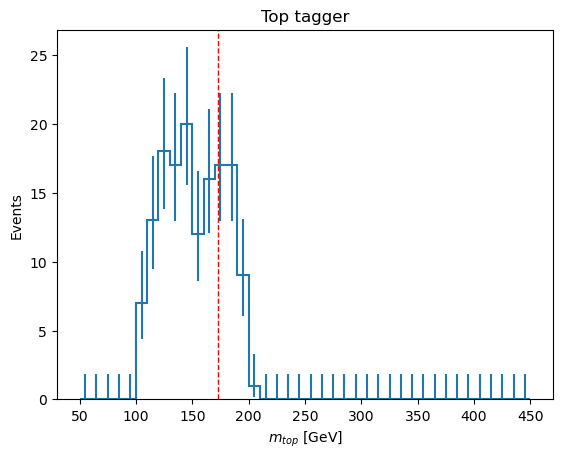

In [8]:
top_I, mask_I = topX.Scenario_I(fatjets, top_low, top_up)
histogram = hist.Hist(
    hist.axis.Regular(
        bins=40, start=50, stop=450, name="mtop", label="$m_{top}$ [GeV]"
    ),
)
histogram.fill(mtop=ak.fill_none(ak.flatten(top_I.mass), False)).plot1d()

plt.axvline(173.1, color='r', linestyle='dashed', linewidth=1)
plt.title('Top tagger')
plt.ylabel('Events')

In [17]:
test = ak.Array([[True,False], [False,True], [False, False], [None]])
ak.any(test, axis = 1)
ak.sum(test)

2

Top tagger_mask_II (True):  0


/opt/conda/lib/python3.8/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


Text(0, 0.5, 'Events')

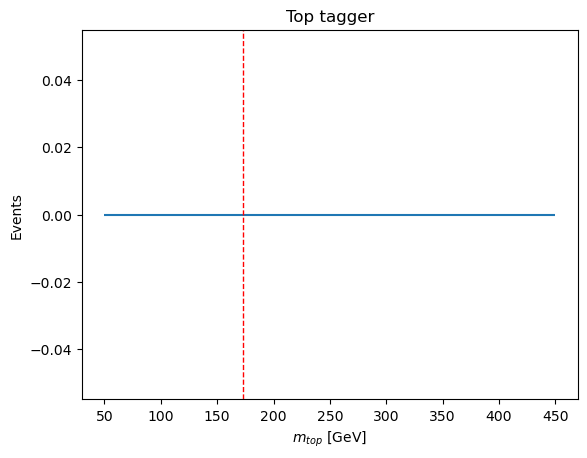

In [15]:
top_II, mask_II = topX.Scenario_II(fatjets, bjets, 
                                    top_low, top_up)
histogram = hist.Hist(
    hist.axis.Regular(
        bins=40, start=50, stop=450, name="mtop", label="$m_{top}$ [GeV]"
    ),
)
histogram.fill(mtop=ak.fill_none(ak.flatten(top_II.mass), False)).plot1d()

plt.axvline(173.1, color='r', linestyle='dashed', linewidth=1)
plt.title('Top tagger')
plt.ylabel('Events')

Top tagger_mask_III (True):  0


/opt/conda/lib/python3.8/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


Text(0, 0.5, 'Events')

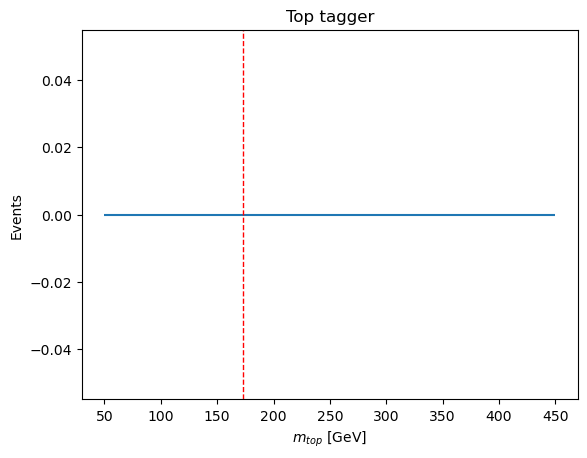

In [10]:
top_III, mask_III = topX.Scenario_III(wjets, bjets, 
                                      top_sigma, top_low, top_up, top_pdg,
                                      w_sigma, w_low, w_up, w_pdg,
                                      chi2)
histogram = hist.Hist(
    hist.axis.Regular(
        bins=40, start=50, stop=450, name="mtop", label="$m_{top}$ [GeV]"
    ),
)
histogram.fill(mtop=ak.fill_none(ak.flatten(top_III.mass), False)).plot1d()

plt.axvline(173.1, color='r', linestyle='dashed', linewidth=1)
plt.title('Top tagger')
plt.ylabel('Events')

Top tagger_mask_IV (True):  0


/opt/conda/lib/python3.8/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


Text(0, 0.5, 'Events')

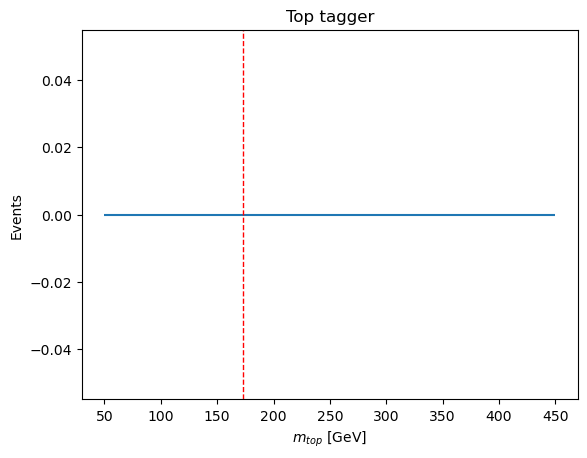

In [11]:
top_IV, mask_IV = topX.Scenario_IV(wjets, bjets, 
                                  top_low, top_up,
                                  w_low, w_up)

histogram = hist.Hist(
    hist.axis.Regular(
        bins=40, start=50, stop=450, name="mtop", label="$m_{top}$ [GeV]"
    ),
)
histogram.fill(mtop=ak.fill_none(ak.flatten(top_IV.mass), False)).plot1d()

plt.axvline(173.1, color='r', linestyle='dashed', linewidth=1)
plt.title('Top tagger')
plt.ylabel('Events')

Top tagger_mask_V (True):  0


/opt/conda/lib/python3.8/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


Text(0, 0.5, 'Events')

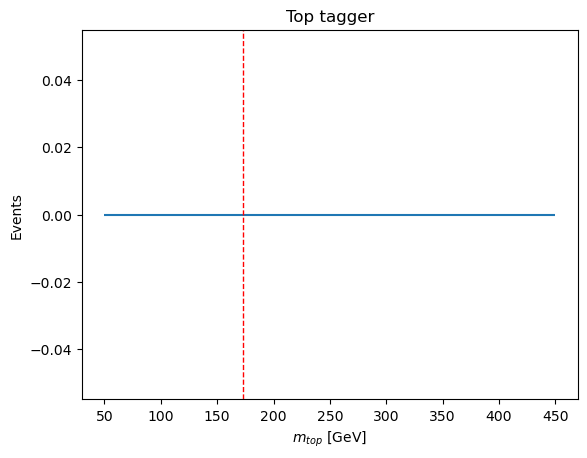

In [12]:
top_V, mask_V = topX.Scenario_V(bjets, wjets,
                                top_sigma, top_low, top_up, top_pdg,
                                w_sigma, w_low, w_up, w_pdg,
                                chi2)
histogram = hist.Hist(
    hist.axis.Regular(
        bins=40, start=50, stop=450, name="mtop", label="$m_{top}$ [GeV]"
    ),
)
histogram.fill(mtop=ak.fill_none(ak.flatten(top_V.mass), False)).plot1d()

plt.axvline(173.1, color='r', linestyle='dashed', linewidth=1)
plt.title('Top tagger')
plt.ylabel('Events')

Top tagger_mask_VI (True):  131 1


Text(0, 0.5, 'Events')

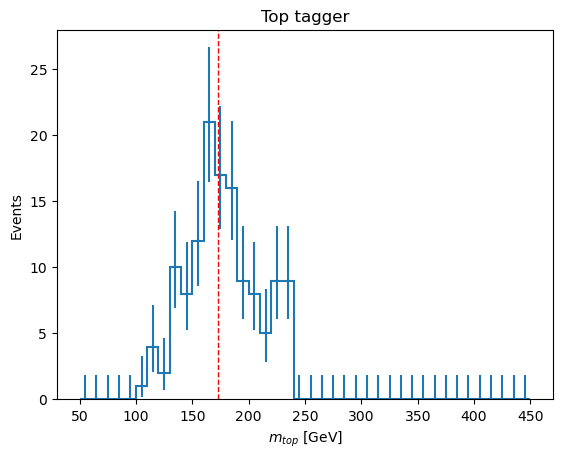

In [44]:
top_VI, mask_VI = topX.Scenario_VI(jets, 
                                      top_sigma, top_low, top_up, top_pdg,
                                      w_sigma, w_low, w_up, w_pdg,
                                      chi2, bjet_wp)
histogram = hist.Hist(
    hist.axis.Regular(
        bins=40, start=50, stop=450, name="mtop", label="$m_{top}$ [GeV]"
    ),
)
histogram.fill(mtop=ak.fill_none(ak.flatten(top_VI.mass), False)).plot1d()

plt.axvline(173.1, color='r', linestyle='dashed', linewidth=1)
plt.title('Top tagger')
plt.ylabel('Events')

Top tagger_mask_VII (True):  48


Text(0, 0.5, 'Events')

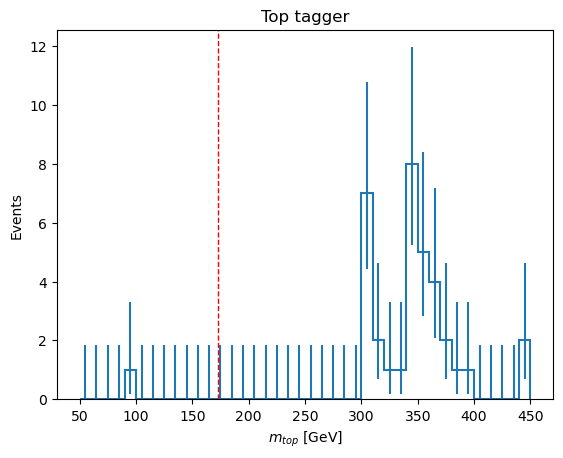

In [14]:
top_VII, mask_VII = topX.Scenario_VII(jets, 
                                      top_low, top_up, 
                                      w_low, w_up, 
                                      bjet_wp)
histogram = hist.Hist(
    hist.axis.Regular(
        bins=40, start=50, stop=450, name="mtop", label="$m_{top}$ [GeV]"
    ),
)
histogram.fill(mtop=ak.fill_none(ak.flatten(top_VII.mass), False)).plot1d()

plt.axvline(173.1, color='r', linestyle='dashed', linewidth=1)
plt.title('Top tagger')
plt.ylabel('Events')

Top tagger_mask_IX (True):  1288 1


Text(0, 0.5, 'Events')

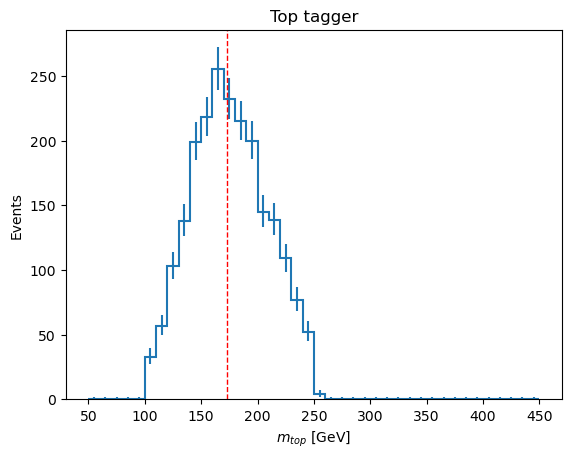

In [32]:
top_IX, mask_IX = topX.Scenario_IX(jets, 
                                  top_sigma, top_low, top_up, top_pdg,
                                  w_sigma, w_low, w_up, w_pdg,
                                  chi2, bjet_wp)
histogram = hist.Hist(
    hist.axis.Regular(
        bins=40, start=50, stop=450, name="mtop", label="$m_{top}$ [GeV]"
    ),
)
histogram.fill(mtop=ak.fill_none(ak.flatten(top_IX.mass), False)).plot1d()

plt.axvline(173.1, color='r', linestyle='dashed', linewidth=1)
plt.title('Top tagger')
plt.ylabel('Events')

In [16]:
# Adding

mask_topXfinder = topTagger_mask(mask_I, mask_II) 
mask_topXfinder = topTagger_mask(mask_topXfinder, mask_III)
mask_topXfinder = topTagger_mask(mask_topXfinder, mask_IV)
mask_topXfinder = topTagger_mask(mask_topXfinder, mask_VI)
mask_topXfinder = topTagger_mask(mask_topXfinder, mask_VII)
mask_topXfinder = topTagger_mask(mask_topXfinder, mask_IX)
    

print("Top tagger_mask_X (all): ", ak.sum(mask_topXfinder))

Top tagger_mask_X (all):  1614


In [14]:
print(mask_I)
print(mask_II)
print(mask_III)
print(mask_IV)
print(mask_V)
print(mask_VI)
print(mask_VII)
print(mask_IX)
print(mask_topXfinder)

NameError: name 'mask_I' is not defined

# Code

In [35]:
import histograms
from coffea.nanoevents.methods.base import NanoEventsArray

In [36]:

syst = "nominal"

# initialize dictionary of hists for control regions
hist_dict = {
    "tau_kin": histograms.ttbar_h_lepton_hist
}


# define dictionary to store analysis variables
features = {}   

# initialize dictionary of arrays
array_dict = {}


# get number of events before selection
nevents = len(events)

# check if sample is MC
is_mc = hasattr(events, "genWeight")

# define systematic variations
syst_variations = ["nominal"]
if is_mc:
    jet_jec_syst_variations = ["JESUp", "JESDown"]
    jet_jer_syst_variations = ["JERUp", "JERDown"]
    met_obj_syst_variations = ["UEUp", "UEDown"]

    if syst == "jec":
        syst_variations.extend(jet_jec_syst_variations)
    elif syst == "jer":
        syst_variations.extend(jet_jer_syst_variations)
    elif syst == "jec":
        syst_variations.extend(jet_jec_syst_variations)
        syst_variations.extend(jet_jer_syst_variations)
    elif syst == "met":
        syst_variations.extend(met_obj_syst_variations)
    elif syst == "full":
        syst_variations.extend(jet_jec_syst_variations)
        syst_variations.extend(jet_jer_syst_variations)
        syst_variations.extend(met_obj_syst_variations)
        

In [47]:
def select_good_electrons(events: NanoEventsArray) -> ak.highlevel.Array:
    return (
                (events.Electron.pt >= 30)
                & (np.abs(events.Electron.eta) <= 2.4)
                & (
                    (np.abs(events.Electron.eta) <= 1.44)
                    | (np.abs(events.Electron.eta) >= 1.57)
                )
                & (events.Electron.cutBased >= 1)
                & (events.Electron.mvaFall17V2Iso_WP90)
            )
    


def select_good_muons(events: NanoEventsArray) -> ak.highlevel.Array:
    return (
                (events.Muon.pt >= 35)
                & (np.abs(events.Muon.eta) <= 2.4)
                & (events.Muon.tightId)
                & (events.Muon.pfRelIso04_all <= 0.15)
            )
    
    

def select_good_taus(events: NanoEventsArray) -> ak.highlevel.Array:
    return (
                (events.Tau.pt >= 20)
                & (np.abs(events.Tau.eta) <= 2.3)
                # github.com/bonanomi/hh2bbww/blob/388efda4e9a6a207d4e983c7f7528acb3a4c374f/hbw/selection/default.py#L295
                & (events.Tau.idDeepTau2017v2p1VSjet >= 6)  # VVVLoose,VVLoose,VLoose,Loose,Medium,Tight,VTight,VVTight
                & (events.Tau.idDeepTau2017v2p1VSe >= 5)    # VVVLoose,VVLoose,VLoose,Loose,Medium,Tight,VTight,VVTight
                & (events.Tau.idDeepTau2017v2p1VSmu >= 4)   # VLoose,Loose,Medium,Tight
                & (np.abs(events.Tau.dz) < 0.2)
                & (events.Tau.idDecayModeNewDMs)    
                & (
                    (events.Tau.decayMode == 0)             # 0 (tau->pi)
                    | (events.Tau.decayMode == 1)           # 1 (tau->rho->pi+pi0)
                    | (events.Tau.decayMode == 1)           # 2 (tau->a1->pi+2pi0)
                    | (events.Tau.decayMode == 10)          # 10 (tau->a1->3pi)
                    | (events.Tau.decayMode == 11)          # 11 (tau->3pi+pi0)
                )
            )

def select_good_Fatjets(fatjets, year="2017", working_point="T"):
    # Wps top tagger, jet_id and jet_eta
    with open("../../jsons/topWps.json", "r") as f: 
        Wps = json.load(f)

    pNet_id = Wps[year]["TvsQCD"][working_point]                      
    jet_id = Wps[year]['jet_id']  
    
    return (
                (fatjets.pt >= 300)
                & (np.abs(fatjets.eta) <= 2.4)
                & (fatjets.particleNet_TvsQCD >= pNet_id)   # Top vs QCD (tight)
                & (fatjets.jetId >= jet_id)                 # tight ID
            )
  

def select_good_Wjets(fatjets, year="2017", working_point="T"):
    # Wps top tagger, jet_id and jet_eta
    with open("../../topWps.json", "r") as f: 
        Wps = json.load(f)
        
    pNet_id = Wps[year]["WvsQCD"][working_point]                      
    jet_id = Wps[year]['jet_id']  
    
    return (
                (fatjets.pt >= 200)
                & (np.abs(fatjets.eta) <= 2.4)
                & (fatjets.particleNet_WvsQCD >= pNet_id)   # W vs QCD (tight) 
                & (fatjets.jetId >= jet_id)   

            )
   

    
def select_good_jets(jets, year="2017"):  
    # Wps top tagger, jet_id and jet_eta
    with open("../../topWps.json", "r") as f: 
        Wps = json.load(f)

        
    jet_eta = Wps[year]['jet_eta']
    jet_id = Wps[year]['jet_id']
      
    return (
                (jets.pt >= 30)           
                & (np.abs(jets.eta) <= jet_eta) 
                & (jets.jetId >= jet_id)                    #  pass tight and tightLepVeto ID.                
                & (jets.puId == 7)                          #  pass loose, medium, tight ID
            )   
    

    
def select_good_bjets(jets, year="2017", working_point="M"):
    # open and load btagDeepFlavB working point
    with importlib.resources.open_text("wprime_plus_b.data", "btagWPs.json") as file:
        btagDeepFlavB = json.load(file)["deepJet"][year][working_point] 
        
    # Wps top tagger, jet_id and jet_eta
    with open("../../jsons/topWps.json", "r") as f: 
        Wps = json.load(f)
   
    jet_eta = Wps[year]['jet_eta']
    jet_id = Wps[year]['jet_id']
    
    return (
                (jets.pt >= 20)
                & (np.abs(jets.eta) <= jet_eta)
                & (jets.jetId >= jet_id)                    #  pass tight and tightLepVeto ID.     
                & (jets.puId == 7)                          #  pass loose, medium, tight ID
                & (jets.btagDeepFlavB >= btagDeepFlavB)
            )

In [48]:
for syst_var in syst_variations:                
   # ------------------
    # leptons
    # -------------------
    # select good electrons
    good_electrons = select_good_electrons(events)
    electrons = events.Electron.mask[good_electrons]
    
    # select good muons
    good_muons = (select_good_muons(events) 
                & delta_r_mask(events.Muon, electrons, threshold=0.4)
    )
    muons = events.Muon.mask[good_muons]

    # select good taus
    good_taus = (select_good_taus(events)
                & (delta_r_mask(events.Tau, electrons, threshold=0.4))
                & (delta_r_mask(events.Tau, muons, threshold=0.4))
    )
    taus = events.Tau.mask[good_taus]
    
    # ------------------
    # Fatjets
    # -------------------            
    # select good Fatjets
    good_fatjets = (select_good_Fatjets(events.FatJet, "2027" + "", working_point=pNet_id_top)
                    & (delta_r_mask(events.FatJet, electrons, threshold=0.4))
                    & (delta_r_mask(events.FatJet, muons, threshold=0.4))
    )
    fatjets = events.FatJet.mask[good_fatjets]

    # select good W jets
    good_wjets = (select_good_Wjets(events.FatJet, "2027" + "", working_point=pNet_id_w)
                    & (delta_r_mask(events.FatJet, electrons, threshold=0.4))
                    & (delta_r_mask(events.FatJet, muons, threshold=0.4))
                    & (delta_r_mask(events.FatJet, fatjets, threshold=0.8))
                 )
    wjets = events.FatJet.mask[good_wjets]

FileNotFoundError: [Errno 2] No such file or directory: 'wprime_plus_b/jsons/topWps.json'